## Autoencoder

An autoencoder is an unsupervised learning technique for neural networks that learns efficient data representations (encoding) by training the network to ignore signal “noise.” Autoencoders can be used for image denoising, image compression, and, in some cases, even generation of image data.

## Flow of Autoencoder

Noisy Image -> Encoder -> Compressed Representation -> Decoder -> Reconstruct Clear Image

## Import Modules

In [51]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, ReLU, Add, Input
from keras.datasets import mnist

# Enable GPU

In [52]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load the Dataset

In [53]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split

# Path to the parent directory where numbered folders exist
base_dir = "/Users/yfahmy/Downloads/mini-english-01-package"
image_dim = 200 # 128 works, lets try 256

# Initialize lists for images and labels
images = []

for folder_num in range(1, 10000): 
    folder_path = os.path.join(base_dir, str(folder_num))
    image_path = os.path.join(folder_path, "01.jpg")

    # Check if the image exists
    if os.path.exists(image_path):
        try:
            img = Image.open(image_path).convert("RGB") 
            img = img.resize((image_dim, image_dim)) 

            images.append(np.array(img)) 
        except Exception as e:
            print(f"Error loading {image_path}: {e}")

images = np.array(images)

x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape(len(x_train), image_dim, image_dim, 3)
x_test = x_test.reshape(len(x_test), image_dim, image_dim, 3)

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (7736, 200, 200, 3), x_test shape: (1935, 200, 200, 3)


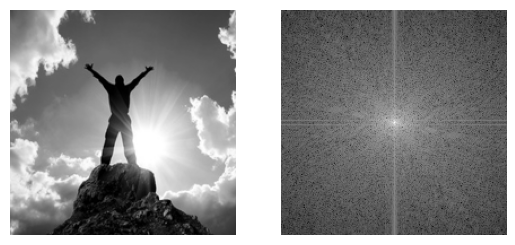

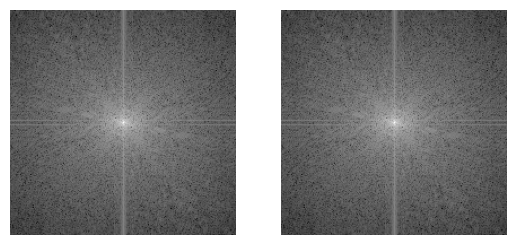

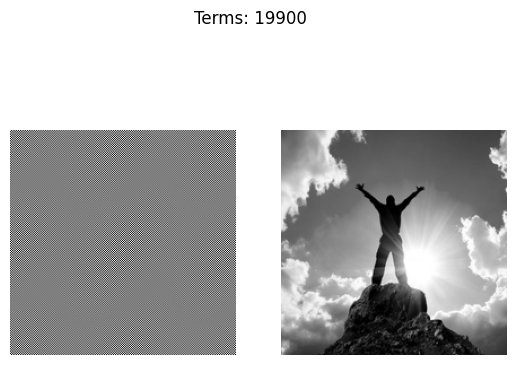

In [81]:
image = x_train[50]

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)

def calculate_2dift(input):
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

def calculate_distance_from_centre(coords, centre):
    # Distance from centre is √(x^2 + y^2)
    return np.sqrt(
        (coords[0] - centre) ** 2 + (coords[1] - centre) ** 2
    )

def find_symmetric_coordinates(coords, centre):
    return (centre + (centre - coords[0]),
            centre + (centre - coords[1]))

def display_plots(individual_grating, reconstruction, idx):
    plt.subplot(121)
    plt.imshow(individual_grating)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(reconstruction)
    plt.axis("off")
    plt.suptitle(f"Terms: {idx}")
    plt.pause(0.01)

# Read and process image
image = image[:, :, :3].mean(axis=2)  # Convert to grayscale

def foureir_transform(image, display=False):
    # Array dimensions (array is square) and centre pixel
    array_size = len(image)
    centre = int((array_size - 1) / 2)

    # Get all coordinate pairs in the left half of the array,
    # including the column at the centre of the array (which
    # includes the centre pixel)
    coords_left_half = (
        (x, y) for x in range(array_size) for y in range(centre+1)
    )

    # Sort points based on distance from centre
    coords_left_half = sorted(
        coords_left_half,
        key=lambda x: calculate_distance_from_centre(x, centre)
    )

    plt.set_cmap("gray")

    ft = calculate_2dft(image)

    if display:
        # Show grayscale image and its Fourier transform
        plt.subplot(121)
        plt.imshow(image)
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(np.log(abs(ft)))
        plt.axis("off")
        plt.pause(2)
        fig = plt.figure()

    return ft


def inverse_fourier_transform(ft, display=False):
    # Reconstruct image

    # Step 1
    # Set up empty arrays for final image and
    # individual gratings
    rec_image = np.zeros(image.shape)
    individual_grating = np.zeros(
        image.shape, dtype="complex"
    )
    idx = 0

    # All steps are displayed until display_all_until value
    display_all_until = 200
    # After this, skip which steps to display using the
    # display_step value
    display_step = 50
    # Work out index of next step to display
    next_display = display_all_until + display_step

    # Step 2
    for coords in coords_left_half:
        # Central column: only include if points in top half of
        # the central column
        if not (coords[1] == centre and coords[0] > centre):
            idx += 1
            symm_coords = find_symmetric_coordinates(
                coords, centre
            )
            # Step 3
            # Copy values from Fourier transform into
            # individual_grating for the pair of points in
            # current iteration
            individual_grating[coords] = ft[coords]
            individual_grating[symm_coords] = ft[symm_coords]

            # Step 4
            # Calculate inverse Fourier transform to give the
            # reconstructed grating. Add this reconstructed
            # grating to the reconstructed image
            rec_grating = calculate_2dift(individual_grating)
            rec_image += rec_grating

            # Clear individual_grating array, ready for
            # next iteration
            individual_grating[coords] = 0
            individual_grating[symm_coords] = 0

            # Don't display every step
            if idx < display_all_until or idx == next_display:
                if idx > display_all_until:
                    next_display += display_step
                    # Accelerate animation the further the
                    # iteration runs by increasing
                    # display_step
                    display_step += 10
    if display:
        display_plots(rec_grating, rec_image, idx)
        plt.show()
    return rec_image

ft = foureir_transform(image, display=True)
plt.subplot(121)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.pause(2)
fig = plt.figure()
rec_image = inverse_fourier_transform(ft, display=True)


## Add Gaussian Noise

In [56]:
noise_factor = 0.075
# Gaussian Noise
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

## Add Salt and Pepper Noise

In [57]:
def add_s_and_p_noise_batch(images, salt_prob=0.01, pepper_prob=0.01):
    N, H, W, C = images.shape
    rand_matrix = np.random.rand(N, H, W)
    salt_mask = rand_matrix < salt_prob
    pepper_mask = rand_matrix > (1 - pepper_prob)
    images[salt_mask] = 255
    images[pepper_mask] = 0
    return images

x_train_noisy = add_s_and_p_noise_batch(x_train_noisy)
x_test_noisy = add_s_and_p_noise_batch(x_test_noisy)

## Calculate Fourier Transform of the Images

In [76]:
# x_train_noisy_fourier = np.array([foureir_transform(image[:,:3]) for image in x_train_noisy])
# x_train_fourier = np.array([foureir_transform(image[:,:3]) for image in x_train])
# x_test_noisy_fourier = np.array([foureir_transform(image[:,:3]) for image in x_test_noisy])
# x_test_fourier = np.array([foureir_transform(image[:,:3]) for image in x_test])

x_train_noisy_fourier = [foureir_transform(image[:,:3]) for image in x_train_noisy]
x_train_fourier = [foureir_transform(image[:,:3]) for image in x_train]
x_test_noisy_fourier = [foureir_transform(image[:,:3]) for image in x_test_noisy]
x_test_fourier = [foureir_transform(image[:,:3]) for image in x_test]


<Figure size 640x480 with 0 Axes>

In [73]:
# clip the values in the range of 0-1
# x_train_noisy_fourier = np.clip(x_train_noisy_fourier, 0., 1.)
# x_test_noisy_fourier= np.clip(x_test_noisy_fourier, 0., 1.)

## Exploratory Data Analysis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.01900401438678..1.9892164597920512].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4252259969625958..6.64547550347933].


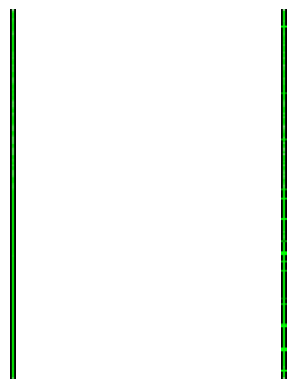

<Figure size 640x480 with 0 Axes>

In [78]:
index = np.random.randint(len(x_test_fourier))
# plt.subplot(121)
# plt.imshow(np.log(abs(x_test_fourier[index])))
# plt.axis("off")
# plt.subplot(122)
# plt.imshow(np.log(abs(x_test_noisy_fourier[index])))
# plt.axis("off")
# plt.pause(2)
# fig = plt.figure()
ft1 = x_test_fourier[index]
print(ft1.size)
ft2 = x_test_noisy_fourier[index]
plt.subplot(121)
plt.imshow(np.log(abs(ft1)))
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft2)))
plt.axis("off")
plt.pause(2)
fig = plt.figure()
# plt.figure(figsize=(20, 10))
# # display original image
# ax = plt.subplot(1, 2, 1)
# plt.imshow(x_test_fourier[index].reshape(image_dim,image_dim,1))
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# ax.set_title("Clean")
# # display noisy image
# ax = plt.subplot(1, 2, 2)
# plt.imshow(x_test_noisy_fourier[index].reshape(image_dim,image_dim,1))
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# ax.set_title("Noisy")
# plt.show()

## Model Creation

In [ ]:
input_img = Input(shape=(image_dim, image_dim, 1))  # RGB images

# First layer (Conv + ReLU)
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)

for _ in range(6): 
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Last layer (Conv, No Activation)
x = Conv2D(3, (3, 3), padding='same')(x)

# Skip Connection (Residual Learning)
output_img = Add()([input_img, x])

model = Model(inputs=input_img, outputs=output_img)

model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
# train the model
model.fit(x_train_noisy_fourier, x_train_fourier, epochs=100 , batch_size=64, shuffle=True, validation_data=(x_test_noisy_fourier, x_test_fourier))

## Visualize the Results

In [ ]:
# predict the results from model (get compressed images)
pred = model.predict(x_test_noisy_fourier)

In [ ]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(20, 10))
# display original image
ax = plt.subplot(1, 3, 1)
plt.imshow(x_test[index].reshape(image_dim,image_dim,1))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Clean")
# display noisy image
ax = plt.subplot(1, 3, 2)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,1))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Noisy")
# display cleaned image
ax = plt.subplot(1, 3, 3)
plt.imshow(inverse_fourier_transform(pred[index].reshape(image_dim,image_dim,1)))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Filtered")
plt.show()